<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### 0.Importação das Bibliotecas Utilizadas 




In [10]:
# coding = utf-8  
#Bibliotecas Básicas 
import pandas as pd
import numpy as np
import json
import nltk
import time  # avaliar
import sys
import unicodedata
import requests
#Bibliotecas de Gráficos e Relatórios 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as ppf
from pandas_profiling import ProfileReport

#Bibliotecas de Análise de Sentimentos
import textblob


### **1.Tratamento do dataset-v2.dat**

##### 1.1. Abrindo o Dataset 

In [85]:
nltk.download('punkt')
! git clone https://github.com/paulordie/sentimental_ds
%cd sentimental_ds/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Cloning into 'sentimental_ds'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 101 (delta 1), reused 6 (delta 1), pack-reused 95
Receiving objects: 100% (101/101), 79.73 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (12/12), done.
/content/sentimental_ds/sentimental_ds/sentimental_ds


##### 1.2 Abrindo e mostrando o Dataset do arquivo .dat


In [17]:
dados = open('dataset-v2.dat')
a = dados.readlines()# Criar uma lista com todos as linhas em strings 
v = [] # vetor para salvar cada linha em json  
#Comando for para correr por cada item de "a" que está as linhas 
for c in a:
  parsed_c = json.loads(c) #Traransformar as strings de "a" em arquivos json
  data = pd.json_normalize(parsed_c) #Normalizando o arquivo json 
  v.append(data)#jogamos os arquivos em 'V'
  #aqui vamos concatenar cada linha que está em 'V' para um unico dataset df 
df = pd.concat(objs=v,axis=0) # Concatenando 

##### 1.3 Salvando em outros formatos

In [20]:
#Montando o local no google drive pra salvar
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")
#Converterndo e Salvando em CSV
df.to_csv('/content/drive/My Drive/dataset123.csv')#salvando o arquivo em csv  \\\\\\\\\\\\\\\\\\\\\verificar
#Convertendo e salvar em excel 
df.to_excel('/content/drive/My Drive/dataset.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 1.4 Exibindo o Head do dataset

In [21]:
df = df.rename(columns={'itemReviewed.name':'Name','itemReviewed.address.streetAddress':'StressAddress','itemReviewed.address.addressLocality':'AddressLocality','itemReviewed.address.addressRegion':'AddressRegion','itemReviewed.address.postalCode':'PostalCode','itemReviewed.address.country':'Country','itemReviewed.website':'Website','itemReviewed.email':'Email','itemReviewed.phoneNumber':'PhoneNumber','itemReviewed.averageRating':'AverageRating'})
df = df.reset_index(drop=True)
df.head(10)

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


In [22]:
df.dtypes

title              object
reviewId           object
restaurantId       object
author             object
reviewBody         object
language           object
mobileDevice       object
userLocation       object
publicationDate    object
visitDate          object
ratingValue        object
Name               object
StressAddress      object
AddressLocality    object
AddressRegion      object
PostalCode         object
Country            object
Website            object
Email              object
PhoneNumber        object
AverageRating      object
dtype: object

In [23]:
df['AverageRating'] = df['AverageRating'].apply(pd.to_numeric) # convertendo para numerico a variave Average Rating 

In [24]:
df.dtypes

title               object
reviewId            object
restaurantId        object
author              object
reviewBody          object
language            object
mobileDevice        object
userLocation        object
publicationDate     object
visitDate           object
ratingValue         object
Name                object
StressAddress       object
AddressLocality     object
AddressRegion       object
PostalCode          object
Country             object
Website             object
Email               object
PhoneNumber         object
AverageRating      float64
dtype: object

###**2. Informações sobre o DataFrame**

In [ ]:
dados['title']

In [ ]:
df_rating = df.groupby(by='AverageRating').count()
df_rating.head()

## 3. Gráfico dos Dados do DataFrame

#### 3.1.Avaliações por Países em ordem decrescente 

In [25]:
# Divide o campo User Location com os valores após a , para uma nova coluna denominadas de Estado e Cidade, https://pt.linkedin.com/pulse/dividindo-colunas-por-delimitador-com-python-fernanda-santos
divisao = df['userLocation'].str.split(',') 
Cidade = divisao.str.get(0) 
Estado = divisao.str.get(1)
df['Cidade'] = Cidade.str.upper()
df['Estado'] = Estado.str.upper()
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating,Cidade,Estado
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,SÃO CARLOS,SP
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,MANAUS,AM
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,GOIÂNIA,GO
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0,ARACAJU,SE
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,RIO DE JANEIRO,RJ


### Estados de Localização dos Usuários x Opiniões

In [26]:
df_Estado = df['Estado'].value_counts().to_frame()[:20] # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Estado.head(10)

,Estado
SP,20673
RJ,9780
MG,6422
DF,5605
RS,5398
BA,4445
PE,4220
CE,3539
PR,3088
GO,2950


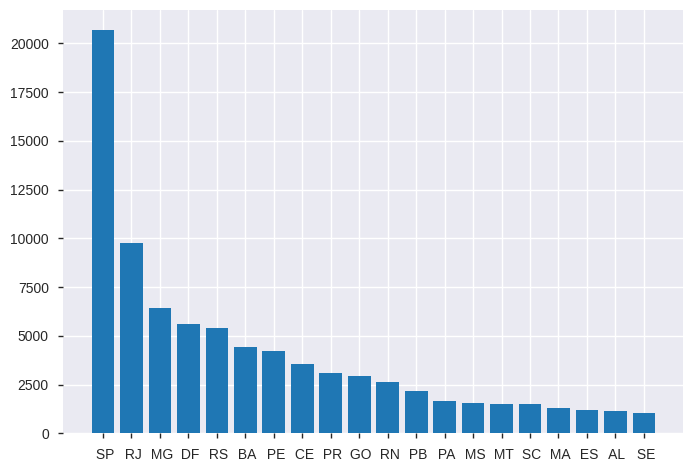

In [ ]:
plt.bar(df_Estado.index,df_Estado['Estado'])
plt.show()

####3.3 Avalições por Estados em ordem descrescente.

In [ ]:
df_Adressregion = df['AddressRegion'].value_counts().to_frame() # https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts https://re-thought.com/pandas-value_counts/https://re-thought.com/pandas-value_counts/
df_Adressregion.head()

,AddressRegion
Estado de São Paulo,17455
Estado do Rio de Janeiro,10583
Rio Grande do Norte,7075
Ceará,6206
Bahia,6030


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

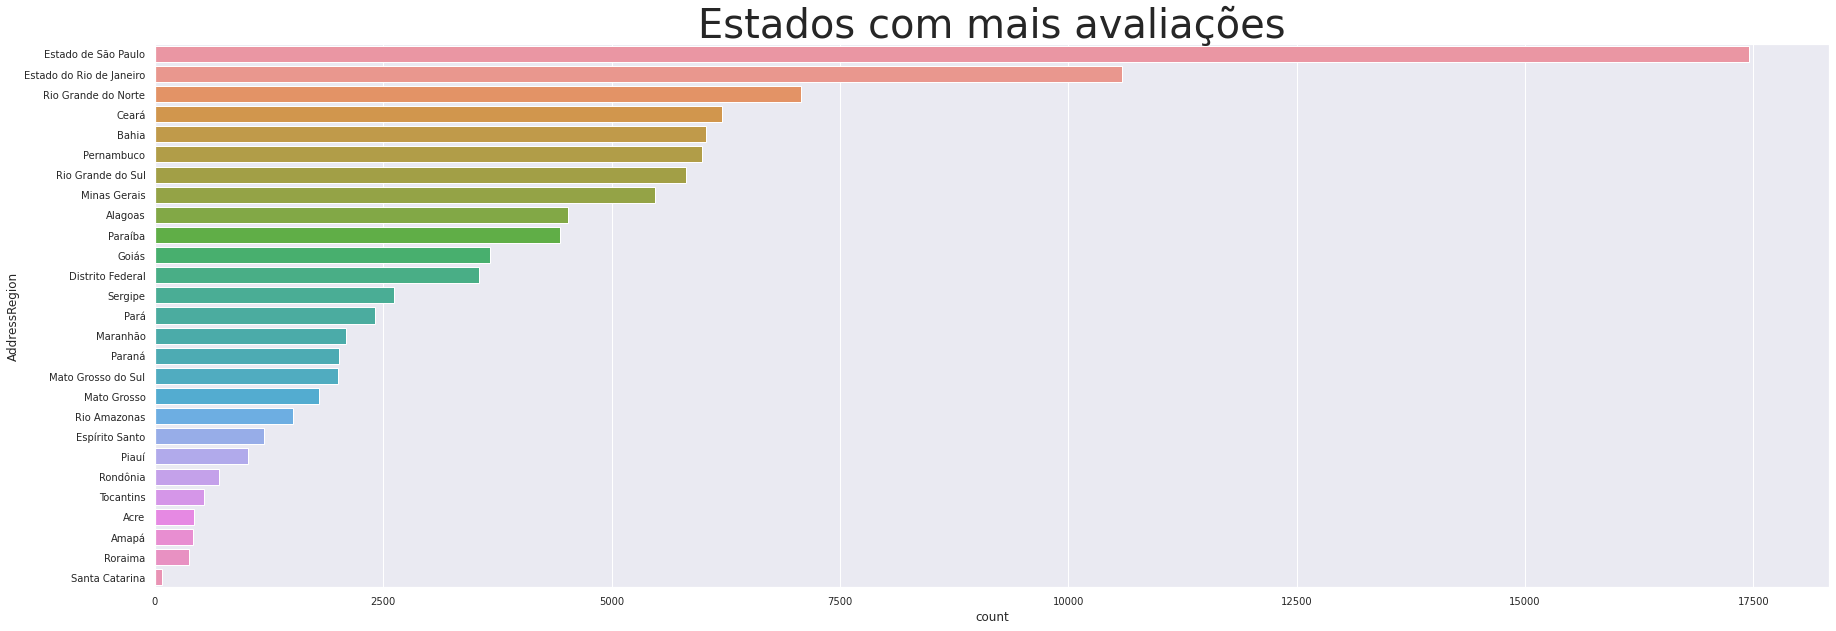

In [ ]:
#Gráfico de Estados com mais avalições em ordem descrescente. 
fig = plt.figure(figsize=(30,10)) 
sns.countplot(y='AddressRegion', order = df['AddressRegion'].value_counts().index, data=df)
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.ylim(0.1,30)

####3.4 Avalições de Estabelecimentos feitas por Amazonenses 

In [ ]:
df_am2.sum()

Name    1506
dtype: int64

In [ ]:
df_am = df[df['AddressRegion']=='Rio Amazonas'] 
df_am.head()
df_am2= df_am['Name'].value_counts().to_frame()
df_am2.head(10)

,Name
Banzeiro,209
Coco Bambu Manaus,154
Cachaçaria do Dedé e Empório - Manauara Shopping,118
Tambaqui de Banda - Parque 10,77
La Parrilla,74
Caxiri Manaus,57
Churrascaria Búfalo,49
Choupana,46
Bar Do Armando,37
Tacacá da Gisela,29


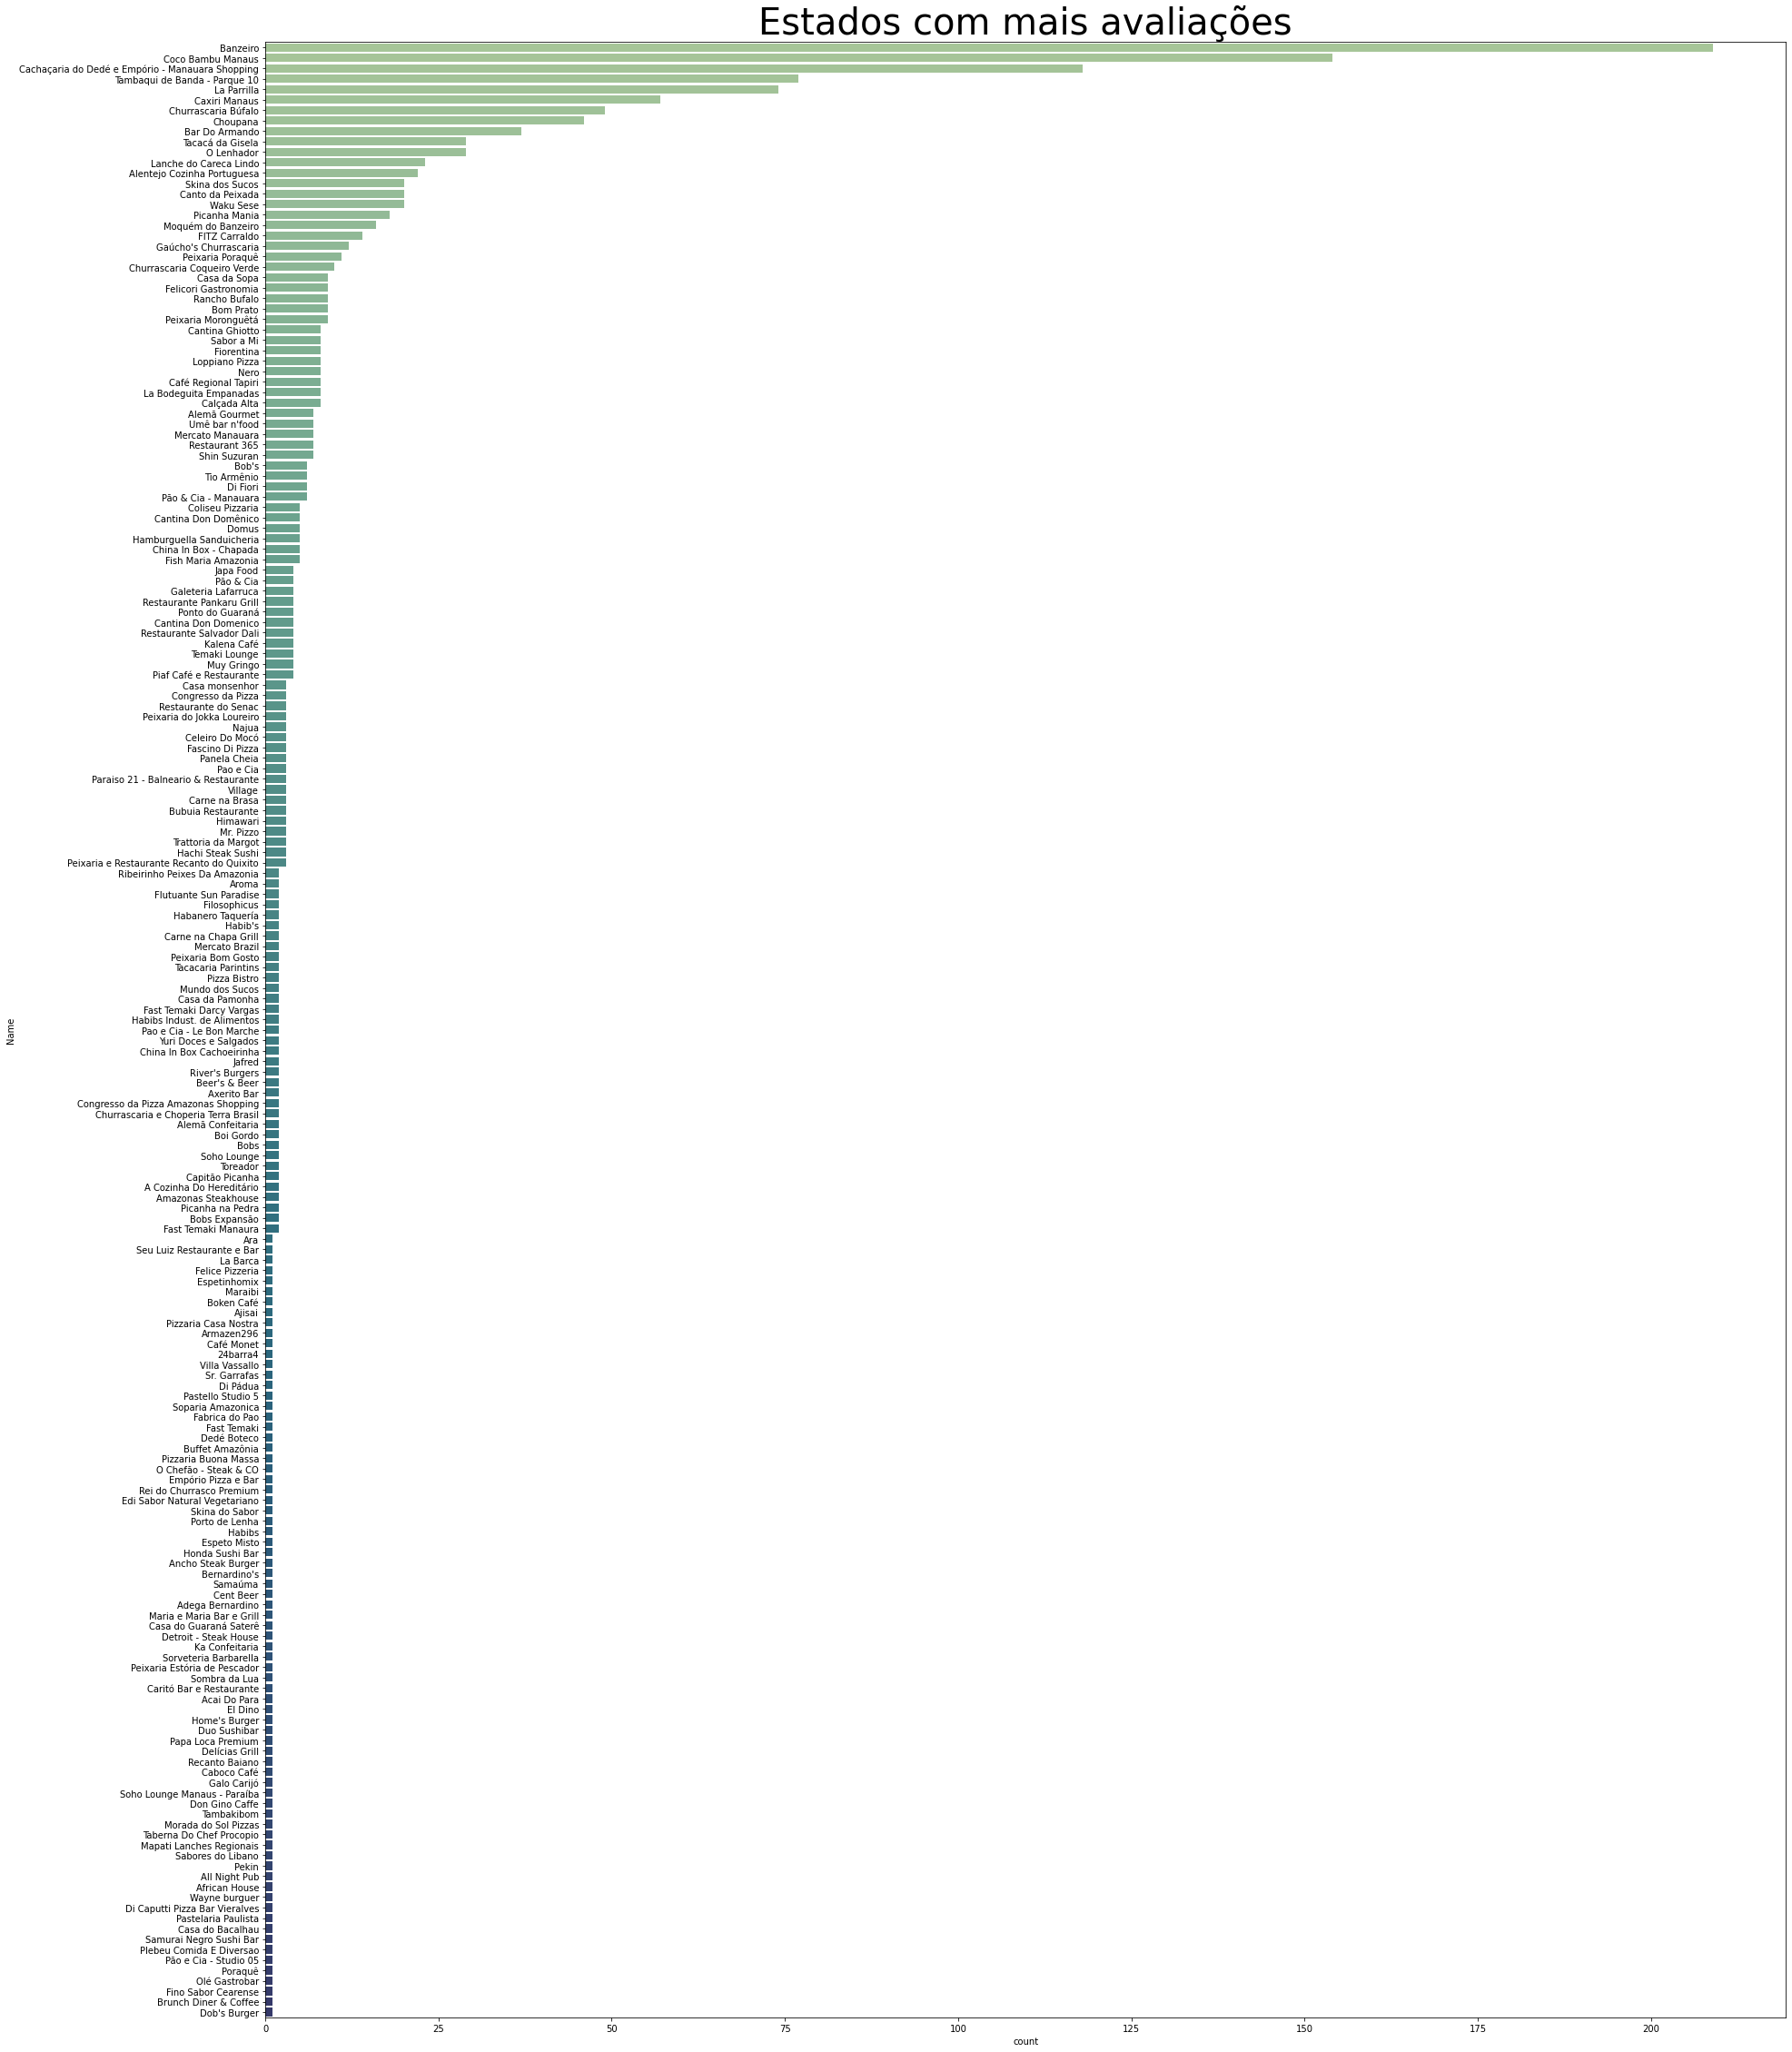

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.title('Estados com mais avaliações',fontsize=40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.countplot(y='Name', order = df_am['Name'].value_counts().index, data=df_am, palette='crest')

### 2. Análise dos Dados do Dataframe

In [ ]:
import pandas_profiling as ppf 
ppf.ProfileReport(df)

In [ ]:
sns.countplot(dados.groupby('publicationDate').userLocation.count());

In [ ]:
dados.groupby('userLocation').averageRating.count().plot()

In [ ]:
sns.countplot(dados.averageRating);

In [ ]:
sns.countplot(dados.ratingValue);

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### Histograma x Comentários 

### 4. Analise dos Sentimentos 

In [ ]:
def translateByTextBlob():
  dic2 = pd.DataFrame(dados)
  dic2['reviewBody']
  count = 0
  for _x in dic2['reviewBody']:
      count = count + 1  
      print(type(_x))
      x = _x.encode('utf-16', 'surrogatepass').decode('utf-16')
      print(x)
      
      print(count) #vai imprimir todos os reviews= 
          
      comentario_blob = TextBlob(x)
      print(type(comentario_blob))
      comentario_blob_us = comentario_blob.translate(to='us')

      for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
          print(sentence_br, ':', sentence.sentiment.subjectivity)
      if count == 5:
          print('**End**')
          break  

In [ ]:
translateByTextBlob()